In [169]:
import dask.dataframe as dd
from IPython.display import display
import numpy as np
import pickle
import matplotlib.pyplot as plt
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import binary_dilation
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def log_func(x, a, b, c):
    return a * np.log(x + b) + c

parquet_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.parquet'
pickle_file_path = 'SimulationResults/UltimateAnalysis/PhasePortraitResourcesPhage/PhasePortraitResourcesPhage.pickle'


with open(pickle_file_path, 'rb') as f:
    pickle_data = pickle.load(f)
print("parameter_names_used", pickle_data['parameter_names_used'])
print("param_values_list_combination", pickle_data['param_values_list_combination'])
print('partition_data', pickle_data['agent_type_count'])
print("agent_type", pickle_data['agent_type'])
print("agent_names", pickle_data['agent_names'])

ddf = dd.read_parquet(parquet_file_path, engine='pyarrow', 
                      include_partition_columns=True, 
                      gather_statistics=True, 
                      dtype_backend='pyarrow')

parameter_names_used ['Resources', 'Phages']
param_values_list_combination [[100.0, 104.04040404040404, 108.08080808080808, 112.12121212121212, 116.16161616161617, 120.20202020202021, 124.24242424242425, 128.2828282828283, 132.32323232323233, 136.36363636363637, 140.40404040404042, 144.44444444444446, 148.4848484848485, 152.52525252525254, 156.56565656565658, 160.60606060606062, 164.64646464646466, 168.6868686868687, 172.72727272727275, 176.7676767676768, 180.80808080808083, 184.84848484848487, 188.8888888888889, 192.92929292929296, 196.96969696969697, 201.010101010101, 205.05050505050505, 209.0909090909091, 213.13131313131314, 217.17171717171718, 221.21212121212122, 225.25252525252526, 229.2929292929293, 233.33333333333334, 237.37373737373738, 241.41414141414143, 245.45454545454547, 249.4949494949495, 253.53535353535355, 257.5757575757576, 261.61616161616166, 265.6565656565657, 269.69696969696975, 273.7373737373738, 277.7777777777778, 281.81818181818187, 285.8585858585859, 289.8989898

In [ ]:
from joblib import Parallel, delayed


matrix = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
matrix2 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
def process_resource(i, resource_value):
    local_matrix = np.zeros(len(pickle_data['param_values_list_combination'][1]))
    local_matrix2 = np.zeros(len(pickle_data['param_values_list_combination'][1]))
    for j, phage_value in enumerate(pickle_data['param_values_list_combination'][1]):
        # print("processing resource", i, "phage", j)
        simulation_results = ddf.query(f'Resources == {resource_value} and Phages == {phage_value}').compute()
        y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
        if np.any(y_values > phage_value * 2):
            local_matrix[j] = np.max(y_values)
            local_matrix2[j] = 1
    return local_matrix, local_matrix2

results = Parallel(n_jobs=-1)(
    delayed(process_resource)(i, resource_value)
    for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
)

for i, (col, col2) in enumerate(results):
    matrix[i, :] = col
    matrix2[i, :] = col2
matrix = matrix.T
matrix2 = matrix2.T

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.         5526.07555631 5703.67018371 5768.46402622 5808.76590304
 5838.33896027 5861.73642125 5880.92217126 5897.23897355 5911.49474726
 5924.10912857 5935.2966885  5945.52066636 5955.02618823 5963.38091546
 5971.66098645 5978.83783959 5986.09747335 5992.48698233 5998.79653622
 6004.67064903 6009.99248882 6015.52740276 6020.54451863 6025.11763582
 6029.9728719  6034.43241822 6038.54032078 6042.61446026 6046.70393715
 6050.50123928 6054.03842217 6057.54218269 6061.13686597 6064.5045149
 6067.66715072 6070.64407046 6073.75678397 6076.83972354 6079.75295659
 6082.51085325 6085.12622597 6087.70452615 6090.45486309 6093.07035171
 6095.56112832 6097.93635849 6100.20433629 6102

/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


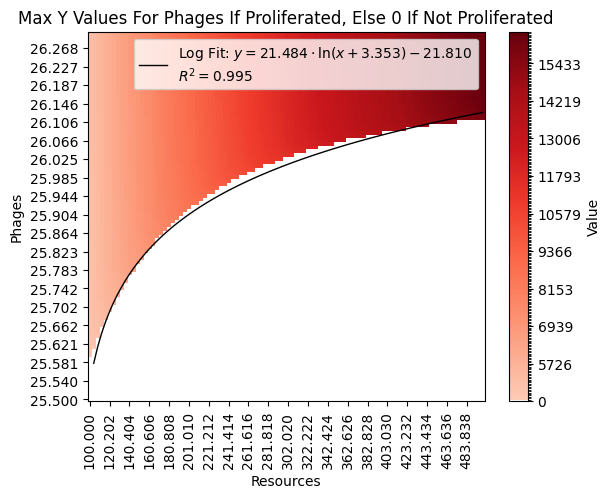

In [172]:
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.imshow(matrix, aspect='auto', origin='lower', cmap='viridis')

boundary = np.logical_xor(matrix2, binary_dilation(matrix2))
y_coords, x_coords = np.where(boundary)
X = x_coords.reshape(-1, 1)
y = y_coords
mask = x_coords > 0
x_log = x_coords[mask]
y_log = y_coords[mask]
popt, _ = curve_fit(log_func, x_log, y_log, p0=(1, 1, 1), maxfev=10000)
x_fit = np.linspace(x_log.min(), x_log.max(), 100)
y_fit = log_func(x_fit, *popt)
y_pred = log_func(x_log, *popt)
r2 = r2_score(y_log, y_pred)
a, b, c = popt
if c < 0:
    label = f'Log Fit: $y = {a:.3f} \cdot \ln(x + {b:.3f}) {c:.3f}$\n$R^2 = {r2:.3f}$'
else:
    label = f'Log Fit: $y = {a:.3f} \cdot \ln(x + {b:.3f}) + {c:.3f}$\n$R^2 = {r2:.3f}$'
plt.plot(x_fit, y_fit, color='black', linewidth=1, label=label)

# Create a custom colormap: black for 0, red to green for >0
colors = ['white'] + [plt.cm.Reds(i) for i in np.linspace(0.2, 1, 255)]
cmap = ListedColormap(colors)
bounds = [0, 1e-10] + list(np.linspace(matrix[matrix > 0].min(), matrix.max(), 255))
norm = BoundaryNorm(bounds, cmap.N)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Value', ax=plt.gca())
plt.imshow(matrix, aspect='auto', origin='lower', cmap=cmap, norm=norm)
plt.xlabel('Resources')
plt.ylabel('Phages')
plt.title('Max Y Values For Phages If Proliferated, Else 0 If Not Proliferated')
xtick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][0]), 5)
xtick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][0])[xtick_indices]]
ytick_indices = np.arange(0, len(pickle_data['param_values_list_combination'][1]), 5)
ytick_labels = [f"{v:.3f}" for v in np.array(pickle_data['param_values_list_combination'][1])[ytick_indices]]
plt.xticks(ticks=xtick_indices, labels=xtick_labels, rotation=90)
plt.yticks(ticks=ytick_indices, labels=ytick_labels)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('LatexReport/Images/Plots/Created/PP/phase_portrait_resources_phage_max_phage_proliferate.png', dpi=300, bbox_inches='tight')

parameter_names_used ['Resources', 'Phages', 'B_matrix']
param_values_list_combination [[100.0, 113.79310344827586, 127.58620689655172, 141.3793103448276, 155.17241379310343, 168.9655172413793, 182.75862068965517, 196.55172413793105, 210.3448275862069, 224.13793103448273, 237.9310344827586, 251.72413793103448, 265.51724137931035, 279.31034482758616, 293.1034482758621, 306.8965517241379, 320.6896551724138, 334.48275862068965, 348.27586206896547, 362.06896551724134, 375.8620689655172, 389.6551724137931, 403.44827586206895, 417.2413793103448, 431.0344827586207, 444.8275862068965, 458.6206896551724, 472.41379310344826, 486.2068965517241, 500.0], [25.5, 25.52758620689655, 25.555172413793102, 25.582758620689656, 25.610344827586207, 25.637931034482758, 25.66551724137931, 25.693103448275863, 25.720689655172414, 25.748275862068965, 25.775862068965516, 25.80344827586207, 25.83103448275862, 25.858620689655172, 25.886206896551723, 25.913793103448278, 25.94137931034483, 25.96896551724138, 25.996551

/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


5.99893346865389 0.4343359013833168 1.975668025156943
Beta: 8, Log Fit: $y = 5.999 \cdot \ln(x + 0.434) + 1.976$
$R^2 = 0.992$
Processing beta value: 9


/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


5.99893346865389 0.4343359013833168 1.975668025156943
Beta: 9, Log Fit: $y = 5.999 \cdot \ln(x + 0.434) + 1.976$
$R^2 = 0.992$
Processing beta value: 10


/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


5.99893346865389 0.4343359013833168 1.975668025156943
Beta: 10, Log Fit: $y = 5.999 \cdot \ln(x + 0.434) + 1.976$
$R^2 = 0.992$
Processing beta value: 11


/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


5.99893346865389 0.4343359013833168 1.975668025156943
Beta: 11, Log Fit: $y = 5.999 \cdot \ln(x + 0.434) + 1.976$
$R^2 = 0.992$
Processing beta value: 12
5.99893346865389 0.4343359013833168 1.975668025156943
Beta: 12, Log Fit: $y = 5.999 \cdot \ln(x + 0.434) + 1.976$
$R^2 = 0.992$


/var/folders/gg/_vl162cs4zs99kls4stdr7xc0000gn/T/ipykernel_49494/3572477454.py:13: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


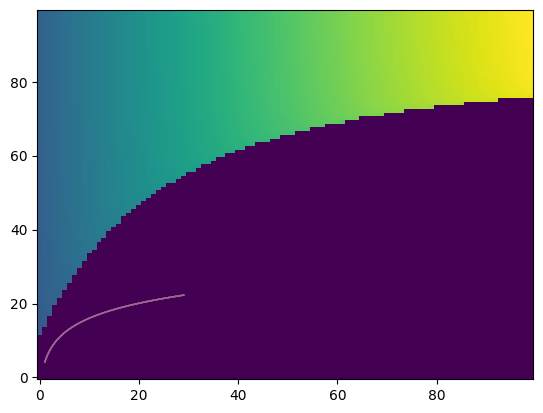

In [ ]:
# parquet_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1748810020/simulation_results_1748810020.parquet'
# pickle_file_path = 'SimulationResults/UltimateAnalysis/SimulationResults_1748810020/simulation_results_1748810020.pickle'
# with open(pickle_file_path, 'rb') as f:
#     pickle_data = pickle.load(f)
# print("parameter_names_used", pickle_data['parameter_names_used'])
# print("param_values_list_combination", pickle_data['param_values_list_combination'])
# print('partition_data', pickle_data['agent_type_count'])
# print("agent_type", pickle_data['agent_type'])
# print("agent_names", pickle_data['agent_names'])

# ddf2 = dd.read_parquet(parquet_file_path, engine='pyarrow', 
#                       include_partition_columns=True, 
#                       gather_statistics=True, 
#                       dtype_backend='pyarrow')

# def beta(beta_val):
#     matrix3 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))
#     matrix4 = np.zeros((len(pickle_data['param_values_list_combination'][0]), len(pickle_data['param_values_list_combination'][1])))

#     def process_resource(i, resource_value):
#         local_matrix = np.zeros(len(pickle_data['param_values_list_combination'][1]))
#         local_matrix2 = np.zeros(len(pickle_data['param_values_list_combination'][1]))
#         for j, phage_value in enumerate(pickle_data['param_values_list_combination'][1]):
#             simulation_results = ddf2.query(f'Resources == {resource_value} and Phages == {phage_value} and B_matrix == {beta_val}').compute()
#             y_values = np.array(ast.literal_eval(simulation_results['y_values'].iloc[0]))[-1, :]
#             if np.any(y_values > phage_value * 2):
#                 local_matrix[j] = np.max(y_values)
#                 local_matrix2[j] = 1
#         return local_matrix, local_matrix2

#     results = Parallel(n_jobs=-1)(
#         delayed(process_resource)(i, resource_value)
#         for i, resource_value in enumerate(pickle_data['param_values_list_combination'][0])
#     )

#     for i, (col, col2) in enumerate(results):
#         matrix3[i, :] = col
#         matrix4[i, :] = col2
#     matrix3 = matrix3.T
#     matrix4 = matrix4.T
#     boundary = np.logical_xor(matrix4, binary_dilation(matrix4))
#     y_coords, x_coords = np.where(boundary)
#     mask = x_coords > 0
#     x_log = x_coords[mask]
#     y_log = y_coords[mask]
#     if len(x_log) == 0 or len(y_log) == 0:
#         return None  # skip if no data
#     popt, _ = curve_fit(log_func, x_log, y_log, p0=(1, 1, 1), maxfev=1000000)
#     x_fit = np.linspace(x_log.min(), x_log.max(), 100)
#     y_fit = log_func(x_fit, *popt)
#     y_pred = log_func(x_log, *popt)
#     r2 = r2_score(y_log, y_pred)
#     a, b, c = popt
#     print(a, b, c)
#     return a, b, c, r2, x_fit, y_fit

# plt.imshow(matrix, aspect='auto', origin='lower', cmap='viridis')
# for beta_val in [8, 9, 10, 11, 12]:
#     print(f"Processing beta value: {beta_val}")
#     result = beta(beta_val)
#     if result is None:
#         print(f"Beta {beta_val}: No data to fit.")
#         continue
#     a, b, c, r2, x_fit, y_fit = result
#     if c < 0:
#         label = f'Log Fit: $y = {a:.3f} \\cdot \\ln(x + {b:.3f}) {c:.3f}$\n$R^2 = {r2:.3f}$'
#     else:
#         label = f'Log Fit: $y = {a:.3f} \\cdot \\ln(x + {b:.3f}) + {c:.3f}$\n$R^2 = {r2:.3f}$'
#     print(f"Beta: {beta_val}, {label}")
#     plt.plot(x_fit, y_fit, linewidth=1, label=f'Beta {beta_val}: {label}')